# Homework, Week 13, Heather Leighton-Dick

In [2]:
#everything and the kitchen sink
import numpy as np
import pandas as pd
import math
import statistics
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.model_selection import cross_val_score

## 1.	Download the dataset here: https://www.kaggle.com/sohier/calcofi and create one DataFrame for the bottle file and another for the cast file. Perform preprocessing on this dataset. You do not need to do all six types of preprocessing we discussed. For this dataset, 2-3 is all you need.

In [48]:
#bottle import

#Waarning on printing out bottle_df.info: 
#Columns ("IncTim" 47 object; "DIC Quality Comment" 73 object) have mixed types. Specify dtype option on import or set low_memory=False.

bottle_file = pd.read_csv("bottle.csv")
bottle_df = pd.DataFrame(bottle_file)
#bottle_df.tail(15)
#bottle_df.info()

#preprocessing -- investigate columns with warnings and fix column formats

#"IncTim" column records incubation time; they are time stamps
bottle_df["IncTim"].value_counts().sum()
bottle_df["IncTim"] = bottle_df["IncTim"].astype("datetime64")

#"DIC Quality Comment" column records "Quality Comments associated with DIC sampling, drawing and analysis"
#the comments are strings containing floats but the column is set as "int64"
bottle_df["DIC Quality Comment"].value_counts()
bottle_df["DIC Quality Comment"] = bottle_df["DIC Quality Comment"].astype("object")

#Columns 67-73 have 2000 or fewer values (in comparison to dataset as whole >800,000 rows)
bottle_df.drop(bottle_df.columns[[67,73]], axis=1)

#I tried dropping rows with "bad" data found via Quality Codes but it cut the dataset in half.
# RecInd = 3 when data is observed; when T_qual and S_qual are equal to "9", the data is missing
#bottle_df = bottle_df[bottle_df["RecInd"] == 3]
#bottle_df = bottle_df[bottle_df["T_qual"] != 9]
#bottle_df = bottle_df[bottle_df["S_qual"] != 9]

#drop columns with Quality Codes because they describe the quality of samples taken 
#and won't be correlated with variables regarding chemical composition (white noise)
bottle_df = bottle_df.drop(columns=["T_qual", "T_prec", "S_qual", "S_prec", "P_qual", "O_qual", "O2Satq", "Chlqua", "Phaqua", "PO4q", "SiO3qu", "NO2q", "NO3q", "NH3q", "C14A1p", "C14A1q", "C14A2p", "C14A2q", "DarkAp", "DarkAq", "MeanAp", "MeanAq"], axis=1)

#drop RecInd, R_Depth, R_TEMP, R_SALINITY rows (R_TEMP and R_SALINITY are duplicates of T_degC and Salnty respectively)
bottle_df = bottle_df.drop(columns=["R_Depth","RecInd", "R_TEMP", "R_SALINITY"], axis=1)

print(len(bottle_df))

864863


In [49]:
#cast import
cast_file = pd.read_csv("cast.csv")
cast_df = pd.DataFrame(cast_file)

#keep columns which may impact data correlation
cast_subset_df = cast_df[["Cst_Cnt", "Quarter", "Month", "Year", "Lat_Deg", "Lon_Deg", "Bottom_D", "Wave_Dir", "Dry_T", "Wet_T" ]]
#cast_subset_df.info()

#join on Cst_Cnt
jn_bot_cast_df = bottle_df.join(cast_subset_df, on="Cst_Cnt", lsuffix="_b", rsuffix="c")
#print(jn_bot_cast_df.dtypes)
jn_bot_cast_df.head()


,Cst_Cnt_b,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,Cst_Cntc,Quarter,Month,Year,Lat_Deg,Lon_Deg,Bottom_D,Wave_Dir,Dry_T,Wet_T
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,2.0,1.0,3.0,1949.0,38.0,-125.0,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,2.0,1.0,3.0,1949.0,38.0,-125.0,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,2.0,1.0,3.0,1949.0,38.0,-125.0,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,2.0,1.0,3.0,1949.0,38.0,-125.0,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,2.0,1.0,3.0,1949.0,38.0,-125.0,NaN,NaN,NaN,NaN


In [54]:
#preprocessing -- null values
#jn_bot_cast_df.isnull().sum()

# I tried to fill the NaNs across the dataframe, but this line of code never stops running
#jn_bot_cast_df.fillna(jn_bot_cast_df.mean())

#Alternate strategy: fill null values in T_degC and Salnty columns
T_degC_mean = jn_bot_cast_df["T_degC"].mean()
Salnty_mean = jn_bot_cast_df["Salnty"].mean()

jn_bot_cast_df["T_degC"] = jn_bot_cast_df["T_degC"].fillna(T_degC_mean)
jn_bot_cast_df["Salnty"] = jn_bot_cast_df["Salnty"].fillna(Salnty_mean)

In [43]:
jn_bot_cast_df.shape

(864863, 58)

In [61]:
print(jn_bot_cast_df.var().head())

Cst_Cnt_b    1.048771e+08
Btl_Cnt      6.233241e+10
Depthm       9.988777e+04
T_degC       1.778175e+01
Salnty       2.016205e-01
dtype: float64


## 2.	Create a correlation matrix to see how the features are correlated. Describe your findings. Pay particular attention to what is correlated with water temperature.

In [51]:
#correlation matrix table
corr_bot_cast_df=jn_bot_cast_df.corr()

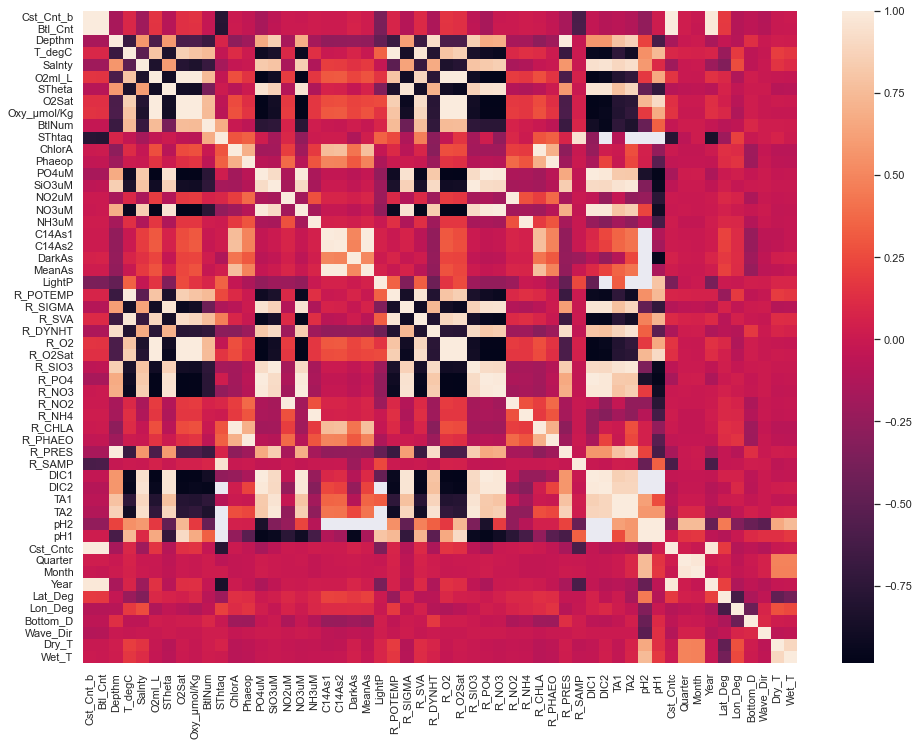

In [64]:
#correlation matrix heat map
sns.set(rc = {'figure.figsize':(16,12)})
heat_bot_cast_df = sns.heatmap(corr_bot_cast_df)
plt.show()

### Findings
T_degC (water temperature) is positively correlated with Oxy_µmol/kg (Oxygen in micro moles per kilogram of seawater), and negatively correlated with R_PO4 (Reported Phosphate Concentration), R_O2Sat (Reported Oxygen Saturation), and SiO3uM (Silicate concentration).

In contrast, salinity is strongly positively correlated with Oxy_µmol/kg, R_PO4, R_O2Sat, and SiO3uM. I hypothesize that the fact that salinity is positively correlated with some of the features that water temperature is negatively correlated with contributed to the weak positive correlation revealed in (3) below.

I was a little surprised that, generally, the time of year and latitude/longitude of the sample collection are hardly correlated at all with water chemical concentrations.

## 3.	Perform linear regression on the dataset to see if you can predict water temperature based on salinity.

In [89]:
# X = salinity (Salnty), y = water temperature(T_degC)
X = jn_bot_cast_df["Salnty"].values
y = jn_bot_cast_df["T_degC"].values

#reshape
y = y.reshape(-1,1)
X = X.reshape(-1,1)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

reg_all.score(X_test, y_test)


0.239862613992621

### The output of 23% seems like a weak relationship.

## 4.	Find your mean squared error and R2 values. Be sure to indicate what these tell you. You can import these from sklearn.metrics.

In [57]:
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.239862613992621
Root Mean Squared Error: 3.675794325873668


### The meaning of R squared and RMSE
The value of R squared is the amount of variance in the target variable predicted from the feature variable; it ranges from 0 (no relationship between variables) and 1 (variables are 100% related). Here, my R squared result is about 0.24, which indicates a weak relationship between salinity and water temperature.

The root mean squared error (RMSE) is a loss function that minimizes the distance from a data point to the fit line. In general, a lower error means that there is less distance between a predicted point in the model and an observed data point in the dataset. An RMSE result of 3.68 indicates that the model is able to predict fairly well where a dataset data point will be.

## 5.	Create a final plot of the relationship between water temperature and salinity. Be sure to show the values from the dataset in a scatter plot with a trend line that shows the predicted temperature values.

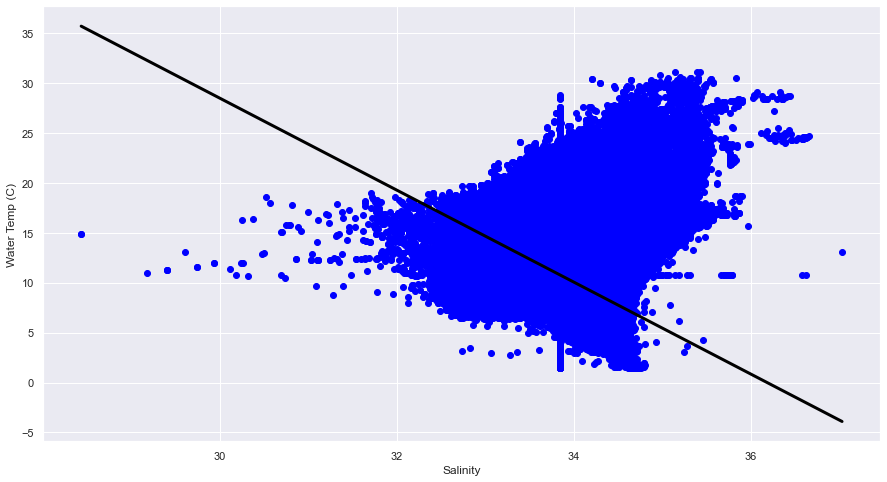

In [58]:
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)

plt.scatter(X,y, color='blue')
plt.plot(prediction_space, reg_all.predict(prediction_space), color='black', linewidth=3)
plt.ylabel("Water Temp (C)")
plt.xlabel("Salinity")
plt.show();

## 6.	Do some research on polynomial regression. Describe what it is and how it works.

###     Polynomial regression is a machine learning algorithm and predictive tool, and is another way to find a line of best fit between data points (attempting to capture as many data points as possible without over/undersimplifying). Polynomial regression lines are curved rather than straight, and are generated by modeling the relationship between the dependent and independent variables as an nth degree polynomial. Using polynomial regression is an option when a dataset is not well-captured or predicted by a linear regression model. For example, population growth and the spread of infectious diseases can be modeled by polynomial regression.

## 7.	Perform polynomial regression on this same dataset. Train and validate your model as you did when you used linear regression. Mean squared error and R2 both apply here.

In [98]:
X = jn_bot_cast_df["Salnty"].values
y = jn_bot_cast_df["T_degC"].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

polynom_model = numpy.poly1d(numpy.polyfit(X, y, 6))


In [101]:
# Compute and print R^2 and RMSE
print("R^2: {}".format(r2_score(y, polynom_model(X))))
mse = mean_squared_error(y, polynom_model(X))
print("Mean Squared Error: {}".format(mse))

R^2: 0.3618357864019037
Mean Squared Error: 11.347664753598549


In [ ]:
# train test split that wouldn't work

# X = salinity (Salnty), y = water temperature(T_degC)
#X = jn_bot_cast_df["Salnty"].values
#y = jn_bot_cast_df["T_degC"].values

#reshape
#y = y.reshape(-1,1)
#X = X.reshape(-1,1)

# Fitting Polynomial Regression to the dataset
#from sklearn.preprocessing import PolynomialFeatures
#poly_reg = PolynomialFeatures(degree=4)
#X_poly = poly_reg.fit_transform(X)
#pol_reg = LinearRegression()
#pol_reg.fit(X_poly, y)

## 8.	Create a final plot of the relationship between water temperature and salinity. Be sure to show the values from the dataset in a scatter plot with a trend line that shows the polynomial regression predicted temperature values. The resulting trend line should be curved.

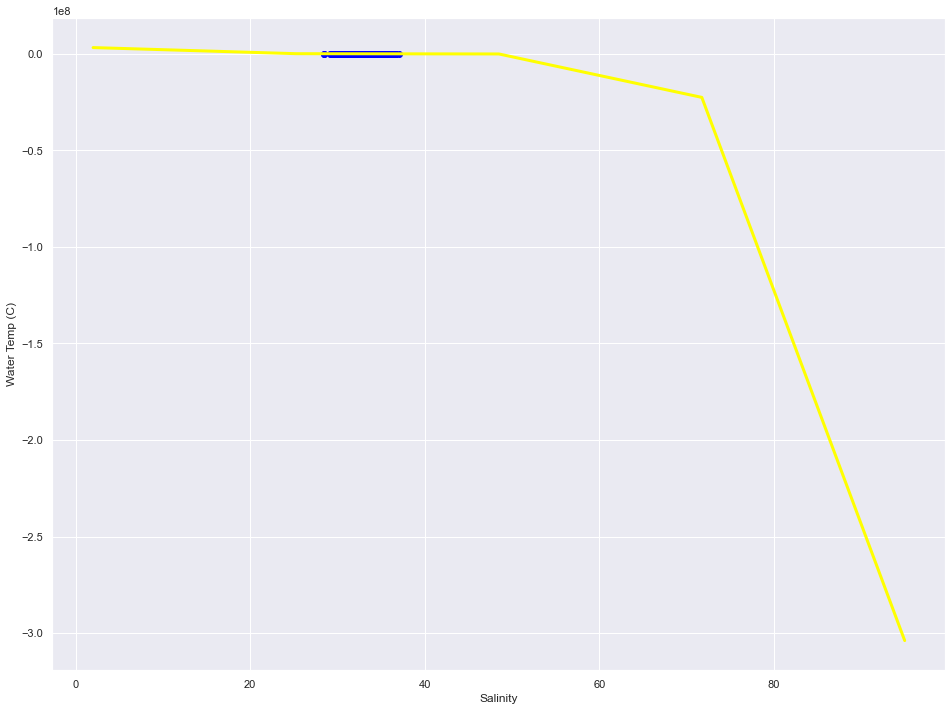

In [107]:
polynom_model = numpy.poly1d(numpy.polyfit(X, y, 6))
polynom_sp = numpy.linspace(2, 95, 5)
plt.scatter(X, y, color='blue')
plt.plot(polynom_sp, polynom_model(polynom_sp), color='yellow', linewidth=3)
plt.ylabel("Water Temp (C)")
plt.xlabel("Salinity")
plt.show();


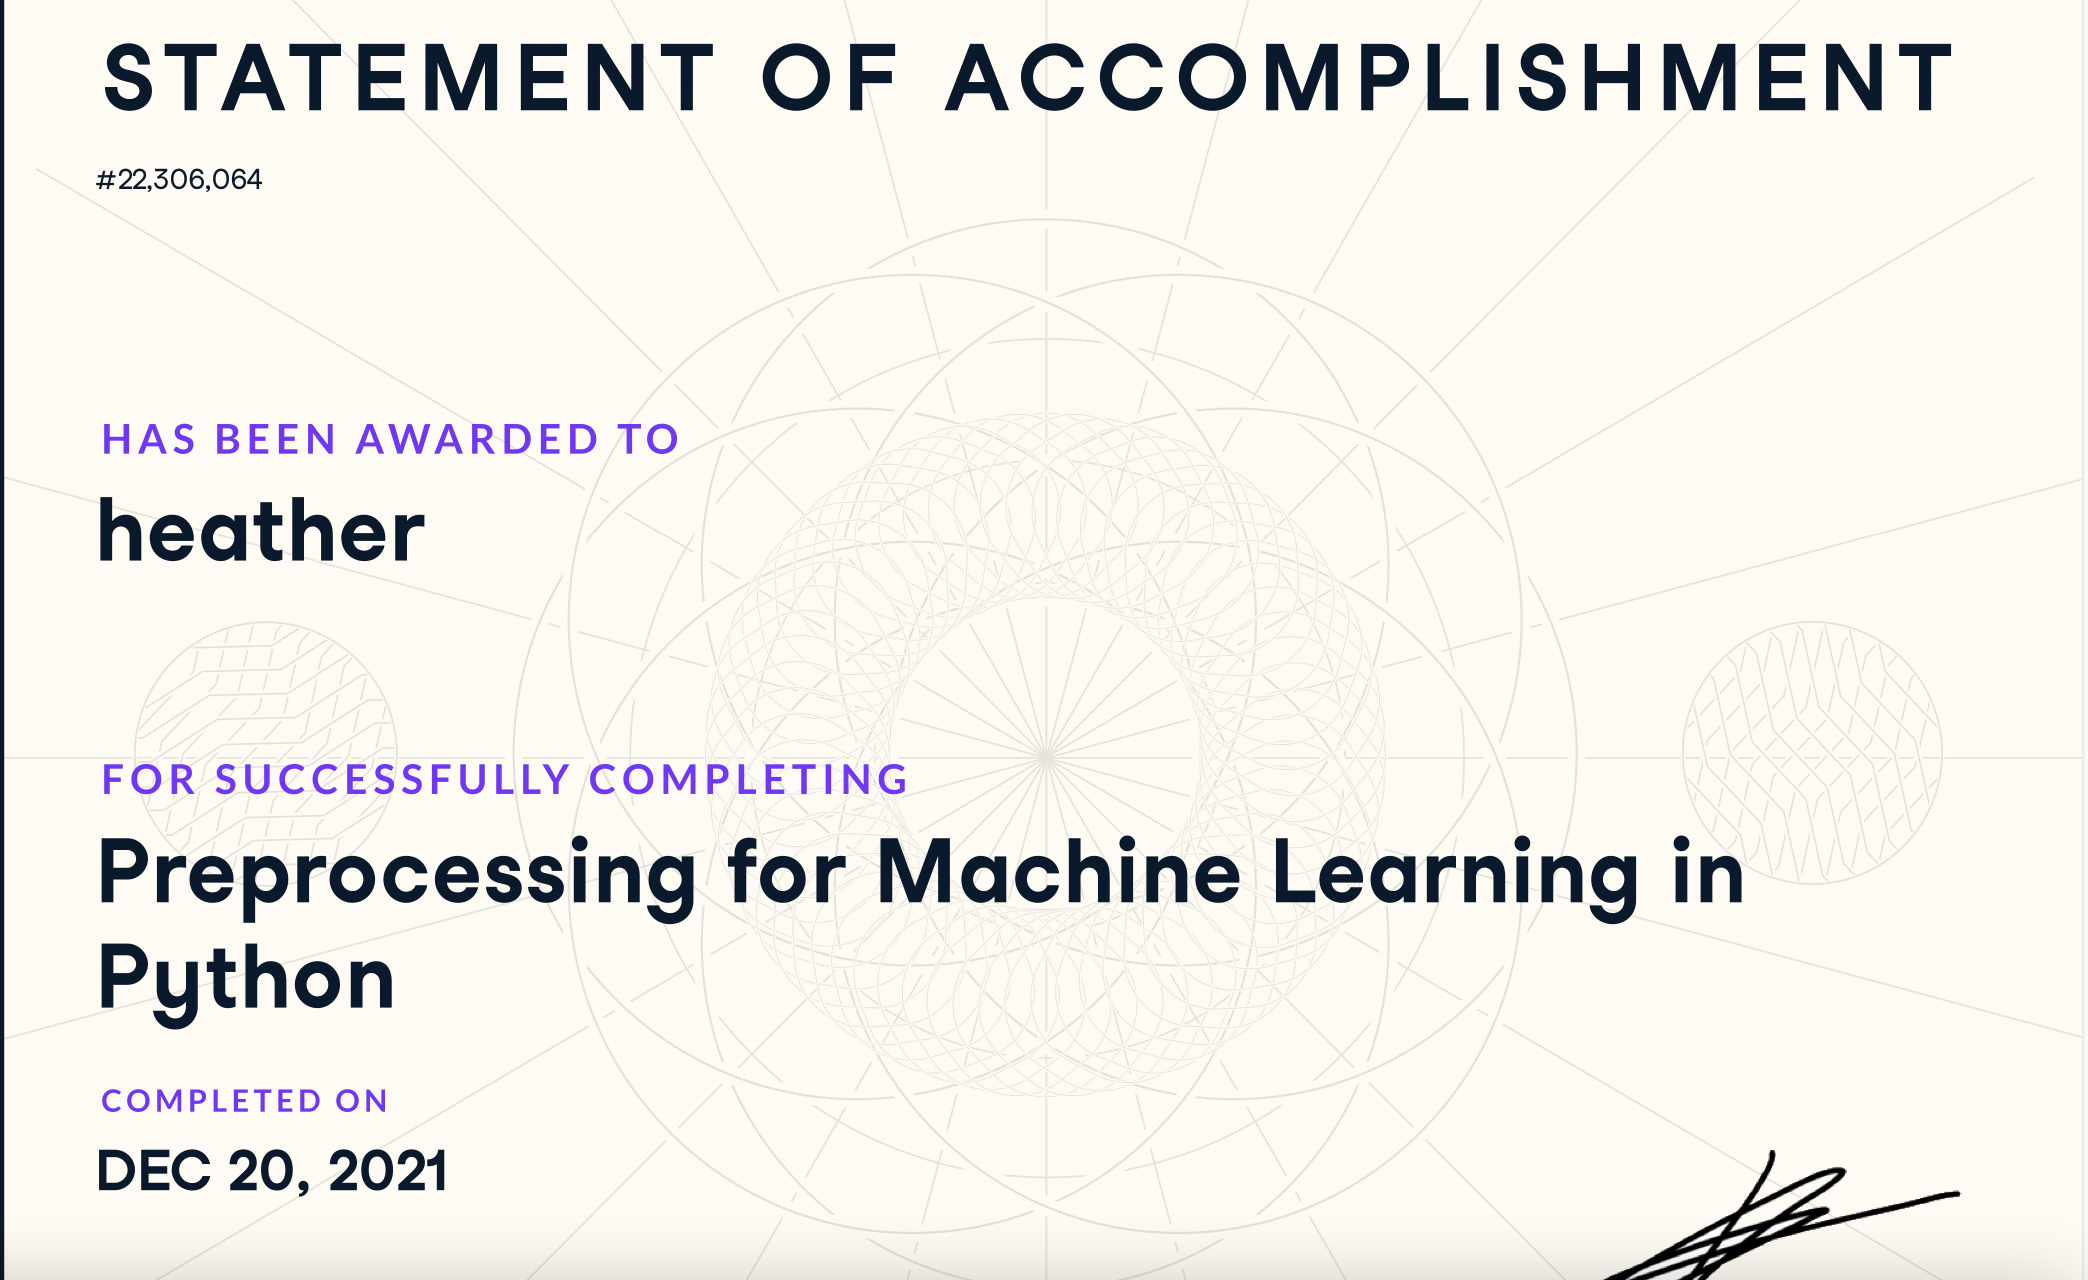

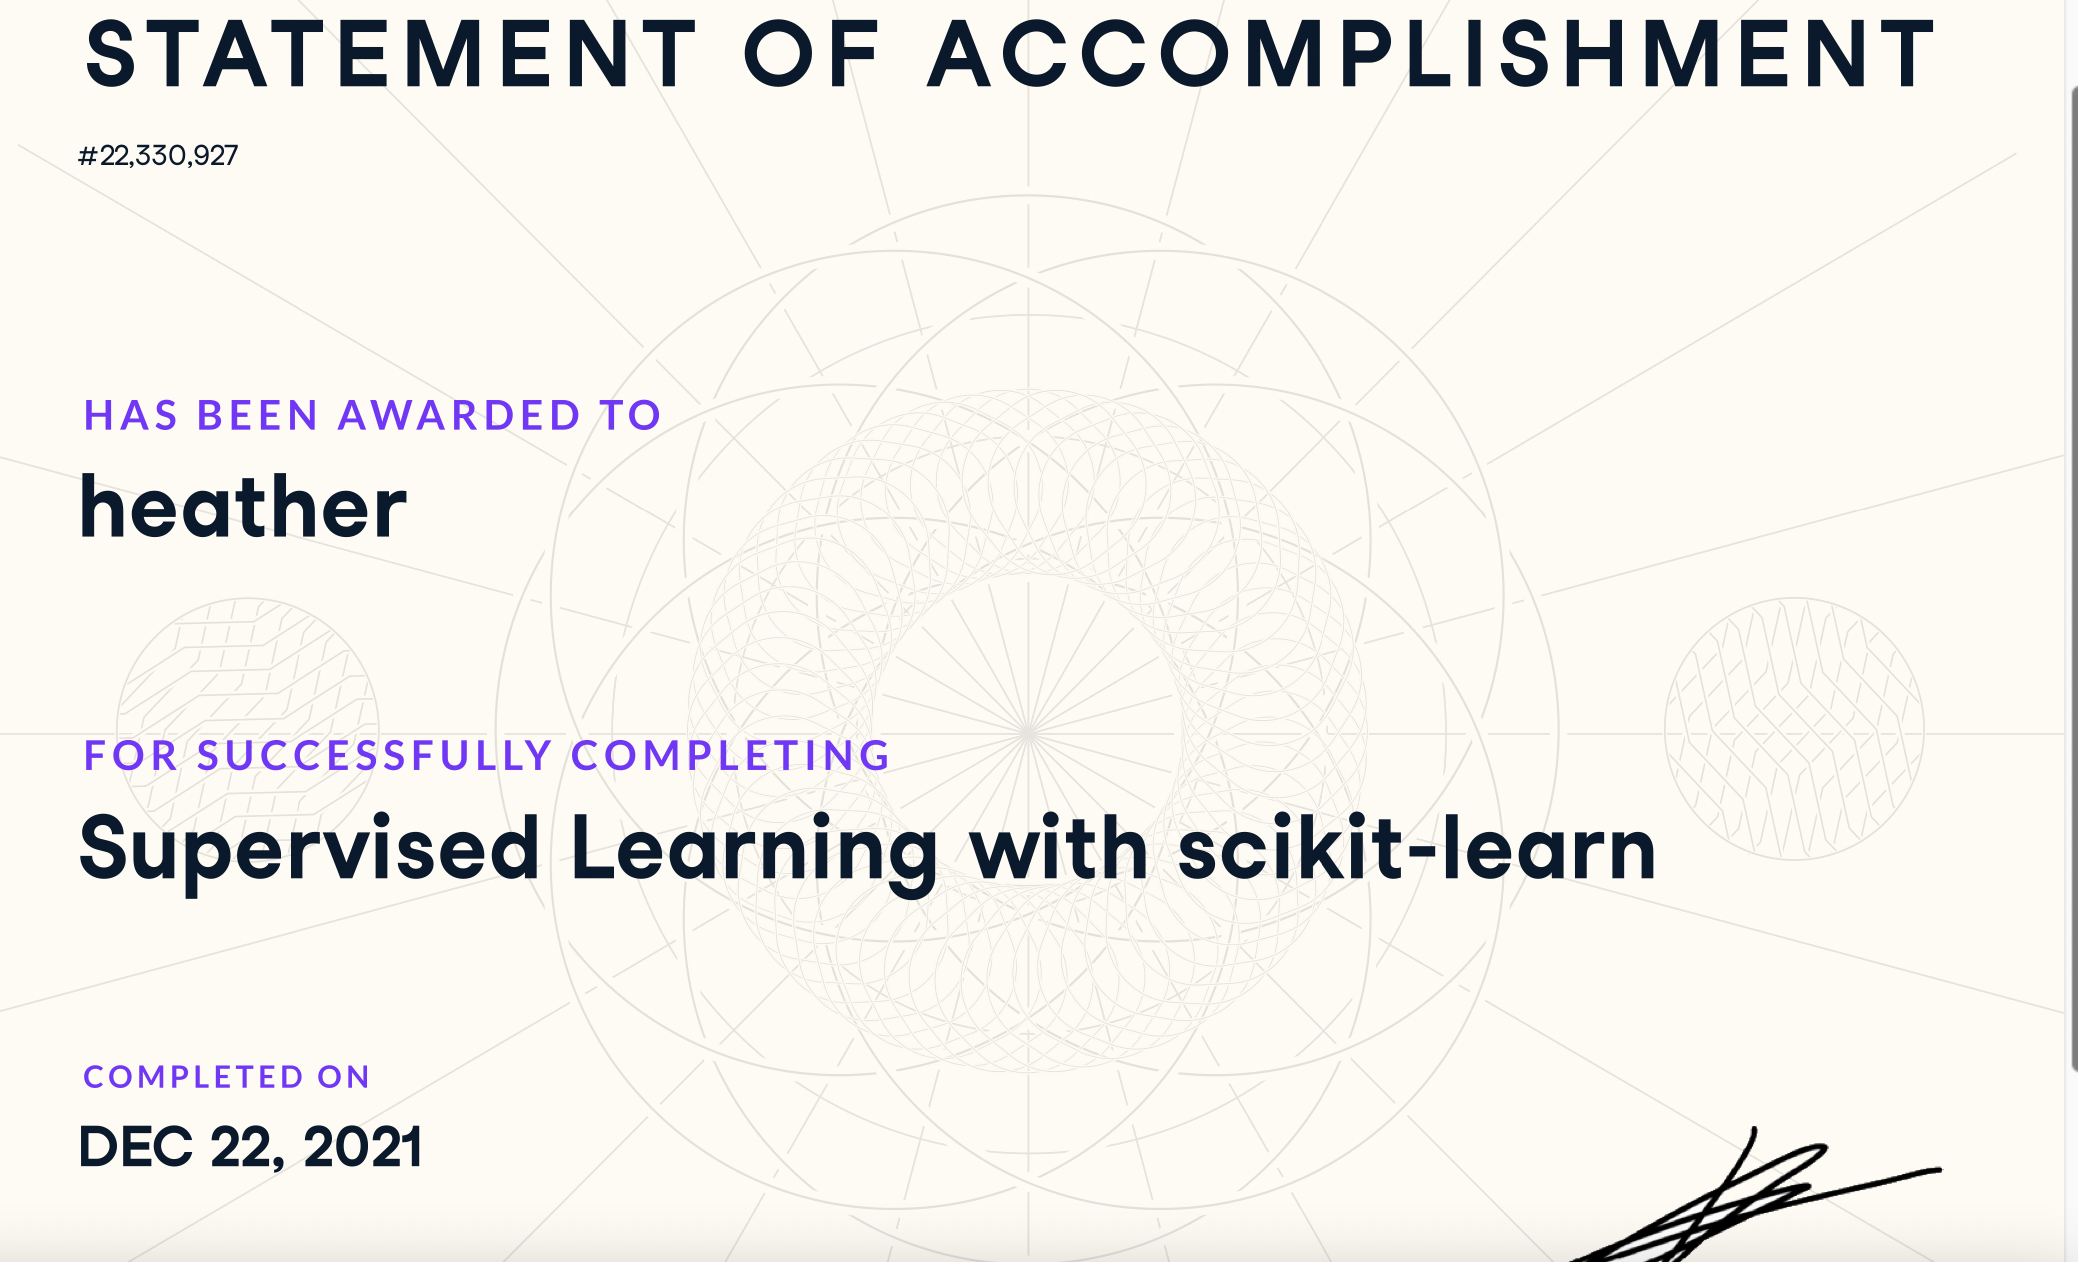